In [3]:
import sys
import os
import time
import numpy as np
import pandas as pd

import torchio as tio

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, BatchSampler, Sampler

sys.path.insert(0, '../../models/')
sys.path.insert(0, '../../scripts/')
sys.path.insert(0, '../../')

from helpers import miscellaneous as misc
from helpers import plotters
from helpers import preprocessing
CONFIG = misc.get_config()

from ModelUtils import EncoderCNN
from ModelUtils import CognitiveTestMLP
from ModelUtils import FusionModel

#get Loader.py
from Loader import MRIDataset

#get TrainUtils.py helpers
from TrainUtils import train

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(device)

idx_to_label = {
    'CN': 0,
    'MCI': 1,
    'AD': 2
}

cuda


In [3]:
#transforms = None # equals no image pre-processing
preprocessor = preprocessing.ADNIPreprocessing(CONFIG)
#transforms = transforms.Compose([preprocessor.normalise()])

# Initialize Image Transformation for model
transforms = (
    tio.CropOrPad((50, 50, 50)),
    tio.RescaleIntensity(out_min_max=(-1, 1), in_min_max=(-1000, 1000))
)
transforms = tio.Compose(transforms)

In [4]:
# Set paths to results
# Add this to config file
metrics_path = CONFIG['METRICS_DIR']
saved_models_path = CONFIG['SERIALIZED_MODELS']

#get dataset 
#change parameters to match config file
dataset = MRIDataset("../../" + CONFIG['TRAIN_LABELS_DIR'], transform = transforms)

#return dataloader with given parameters
train_loader = DataLoader(
    dataset = dataset,
    batch_size = 64, 
    num_workers = 4, 
    shuffle = True,
    pin_memory = True,
)

learning_rate = 0.01
max_epochs = 1

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
        torch.nn.init.xavier_uniform_(m.weight.data)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = EncoderCNN(3).to(device)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
print("length dataset: ", len(dataset))

length dataset:  1699


Process until it starts training is really long. So maybe another approach is better.

start epoch
tensor([[0.4056, 0.2098, 0.3846],
        [0.2117, 0.4670, 0.3212],
        [0.2620, 0.0682, 0.6697],
        [0.1376, 0.1209, 0.7415],
        [0.1707, 0.4886, 0.3406],
        [0.4268, 0.2581, 0.3152],
        [0.2629, 0.2692, 0.4679],
        [0.7818, 0.0556, 0.1625],
        [0.4963, 0.0534, 0.4503],
        [0.0656, 0.0250, 0.9095],
        [0.5628, 0.2779, 0.1593],
        [0.3048, 0.5302, 0.1650],
        [0.0782, 0.6126, 0.3092],
        [0.0823, 0.4390, 0.4787],
        [0.2292, 0.2659, 0.5049],
        [0.6338, 0.0225, 0.3438],
        [0.2217, 0.4511, 0.3272],
        [0.4621, 0.1354, 0.4026],
        [0.5247, 0.3514, 0.1239],
        [0.3665, 0.3495, 0.2840],
        [0.0739, 0.5035, 0.4226],
        [0.2697, 0.1994, 0.5309],
        [0.4499, 0.0570, 0.4931],
        [0.2960, 0.5480, 0.1560],
        [0.1255, 0.1203, 0.7542],
        [0.5975, 0.3464, 0.0561],
        [0.2270, 0.3029, 0.4702],
        [0.2789, 0.4637, 0.2573],
        [0.1364, 0.6857, 0.1779],
  

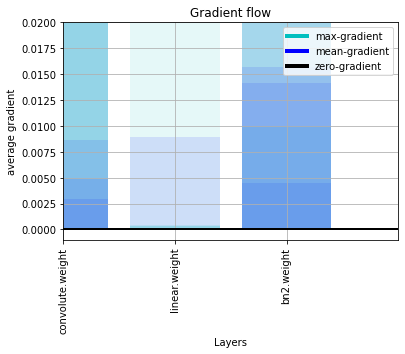

In [5]:
# %%time

# Train model
results = train(train_loader, model, optimizer, max_epochs, device)

In [6]:
# Save model
run_name = "TEST-NeuronFusionExcessiveGigaNet-18"
results.to_csv("../../" + metrics_path + run_name + ".csv", index=False)
torch.save(model, "../../" + saved_models_path + run_name + ".pth")